In [1]:


# needed packages
import numpy as np
# import matplotlib
import matplotlib.pyplot as plt
# import re
from astropy.io import fits
import pyds9
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
# import needed functions from the toolbox
from ccd_tools import bias_subtract, background_subtract, get_regions

def flat_Gaussian_2d(indata, amplitude, x0, y0, sigma_x, sigma_y, offset):
    """Define gaussian function, assuming no correlation between x and y.

    Uses a flattened input, and gives a flattened output

    Parameters
    ----------
    indata: array int
        indata is a pair of arrays, each array corresponding to the x indice or y indice, in the form (x, y)
    amplitude: float
        represents the total flux of the object being fitted
    x0: float
        horizontal center of the object
    y0: float
        vertical center of the object
    sigma_x: float
        half width half maximum of the object along the horizontal
    sigma_y: float
        half width half maximum of the object along the vertical
    offset: float
        represents the background around the object
    """
    import numpy as np
    x, y = indata
    normalize = 1 / (sigma_x * sigma_y * 2 * np.pi)

    gaussian_fun = offset + amplitude * normalize * np.exp(
        -(x - x0) ** 2 / (2 * sigma_x ** 2) - (y - y0) ** 2 / (2 * sigma_y ** 2))

    return gaussian_fun.ravel()


def Gaussian_2d(indata, amplitude, x0, y0, sigma_x, sigma_y, offset):
    """same as Guassian_2D, but does not flatten the result.

    This function is used for producing a 2d array of the result from the fit

    Parameters
    ----------
    indata: array int
        indata is a pair of arrays, each array corresponding to the x indice or y indice, in the form (x, y)
    amplitude: float
        represents the total flux of the object being fitted
    x0: float
        horizontal center of the object
    y0: float
        vertical center of the object
    sigma_x: float
        half width half maximum of the object along the horizontal
    sigma_y: float
        half width half maximum of the object along the vertical
    offset: float
        represents the background around the object
    """
    import numpy as np
    x, y = indata
    normalize = 1 / (sigma_x * sigma_y * 2 * np.pi)

    gaussian_fun = offset + amplitude * normalize * np.exp(
        -(x - x0) ** 2 / (2 * sigma_x ** 2) - (y - y0) ** 2 / (2 * sigma_y ** 2))

    return gaussian_fun


def elliptical_Moffat(indata, flux, x0, y0, beta, a, b, theta, offset):
    """Model of PSF using a single Moffat distribution, with elliptical parameters.

    Parameters
    ----------
    indata: list
        a list of 2 arrays. The first array is the x values per data point. The
        second array is the y values per data
        point
    flux: float
        Represents the total flux of the object
    x0: float
        horizontal location of the centroid
    y0: float
        vertical location of the centroid
    beta: float
        change in slope parameter
    a: float
        width parameter in the x direction
    b: float
        width parameter in the y direction
    theta: float
        angle of eccentricity
    offset: float
        estimate of background. Should be zero

    Returns
    -------
    moffat_fun: array-like
        array of data values corresponding to the x and y inputs
    """
    x_in, y_in = indata

    # moffat_fun = offset + flux * normalize * (1 + ((x - x0)**2/a**2 + (y - y0)**2/b**2))**(-beta)
    A = np.cos(theta)**2/a**2 + np.sin(theta)**2/b**2
    B = 2*np.cos(theta)*np.sin(theta)*(1/a**2 - 1/b**2)
    C = np.sin(theta)**2/a**2 + np.cos(theta)**2/b**2

    def moffat_fun(x, y): return (1 + A*(x - x0)**2 + B*(x - x0)*(y - y0) + C*(y - y0)**2)**(-beta)

    # numerical normalization
    # scale steps according to the size of the array.

    x_final = np.amax(x_in) + 20
    y_final = np.amax(y_in) + 20
    x_start = np.amin(x_in) - 20
    y_start = np.amin(y_in) - 20
    # delta_x = .1
    # delta_y = .1

    h = 300
    k = 300

    delta_x = (x_final-x_start)/h
    delta_y = (y_final-y_start)/k

    # create a grid of x and y inputs
    x_step, y_step = np.meshgrid(np.arange(x_start + delta_x/2, x_final + delta_x/2, delta_x), np.arange(y_start + delta_y/2, y_final + delta_y/2, delta_y))

    # sum up the function evaluated at the steps, and multiply by the area of each step
    normalize = np.sum(moffat_fun(x_step, y_step))*delta_x*delta_y
    # normalize = 1

    # forget that, just integrate it
    # normalize, norm_err = dblquad(moffat_fun, -np.inf, np.inf, lambda x: -np.inf, lambda x: np.inf)

    output = offset + flux*moffat_fun(x_in, y_in)/normalize

    return output


def flat_elliptical_Moffat(indata, flux, x0, y0, beta, a, b, theta, offset):
    """Model of PSF using a single Moffat distribution, with elliptical parameters.

    Includes a parameter for  axial alignment. This function flattens the
    output, for curve fitting.

    Parameters
    ----------
    indata: list
        a list of 2 arrays. The first array is the x values per data point. The
        second array is the y values per data point.
    flux: float
        Represents the total flux of the object
    x0: float
        horizontal location of the centroid
    y0: float
        vertical location of the centroid
    beta: float
        change in slope parameter
    a: float
        width parameter in the x direction
    b: float
        width parameter in the y direction
    theta: float
        angle of eccentricity
    offset: float
        estimate of background. Should be zero

    Returns
    -------
    moffat_fun.ravel(): flattened array-like
        array of data values produced from the x and y inputs. Flattened, for
        curve fitting
    """
    x_in, y_in = indata

    # moffat_fun = offset + flux * normalize * (1 + ((x - x0)**2/a**2 + (y - y0)**2/b**2))**(-beta)
    A = np.cos(theta) ** 2 / a ** 2 + np.sin(theta) ** 2 / b ** 2
    B = 2 * np.cos(theta) * np.sin(theta) * (1 / a ** 2 - 1 / b ** 2)
    C = np.sin(theta) ** 2 / a ** 2 + np.cos(theta) ** 2 / b ** 2

    def moffat_fun(x, y): return (1 + A*(x - x0)**2 + B*(x - x0)*(y - y0) + C*(y - y0)**2)**(-beta)

    # numerical normalization
    # scale steps according to the size of the array.

    x_final = np.amax(x_in) + 20
    y_final = np.amax(y_in) + 20
    x_start = np.amin(x_in) - 20
    y_start = np.amin(y_in) - 20
    # delta_x = .1
    # delta_y = .1

    h = 300
    k = 300

    delta_x = (x_final-x_start)/h
    delta_y = (y_final-y_start)/k

    # create a grid of x and y inputs
    x_step, y_step = np.meshgrid(np.arange(x_start + delta_x/2, x_final + delta_x/2, delta_x), np.arange(y_start + delta_y/2, y_final + delta_y/2, delta_y))

    # sum up the function evaluated at the steps, and multiply by the area of each step
    normalize = np.sum(moffat_fun(x_step, y_step))*delta_x*delta_y
    # normalize = 1

    # forget that, just integrate it
    # normalize, norm_err = dblquad(moffat_fun, -np.inf, np.inf, lambda x: -np.inf, lambda x: np.inf)

    output = offset + flux*moffat_fun(x_in, y_in)/normalize

    return output.ravel()


ds9 target instance
['DS9:ds9 7f000101:45347']
Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  im1           1 PrimaryHDU     177   (2112, 2112)   int32   


Region Coordinate system:
image
Selected Regions:
box(1378.0866,987.7798,84.600115,74.800151,359.99999)
Region resolved
box(1671.1933,957.01609,74.399905,51.600028,359.99999)
Region resolved
box(1681.5119,1331.8622,105.40808,100.22413,359.99999)
Region resolved
box(872.26018,550.0469,91.58387,101.952,359.99999)
Region resolved
box(1282.725,231.604,101.95203,95.040137,359.99999)
Region resolved
box(1089.4422,1173.1765,103.68006,74.304163,359.99999)
Region resolved
box(893.07248,1213.0923,72.575962,72.575909,359.99999)
Region resolved
box(289.15412,1467.1033,81.216095,69.12017,359.99999)
Region resolved
box(277.10537,1803.7691,77.635621,80.621458,359.99999)
Region resolved
box(773.59814,1791.9033,54.166662,44.166762,359.99999)
Region resolved
box(864.41778,1881.9827,52.499883,45.000083,359.99999)
Region resolved
box(925.67409,1955.6481,29.999983,33.333325,359.99999)
Region resolved
Bias Section is [2066:2112,18:2065]
['2066', '2112', '18', '2065']


Bias mean: 3357.8910266636885
Bias median: 3358.0
Bias standerd deviation: 4.497718312071435


---------------------


Background mean: 3990.882317110493
Background median: 3989.9026904055395
Background standerd deviation: 63.56509426829007


Resultant parameters
Flux: 927775.73±1703.19
Center (x, y): 49.23±0.00, 51.12±0.00
beta: 3.36±0.03
x-axis eccentricity: 4.11±0.03
y-axis eccentricity: 4.37±0.03
angle of eccentricity(Radians: 0.677±0.017
background: 1.77±0.71
Normalized chi squared: 
1.1240857511581404


/home/lee/anaconda3/lib/python3.6/site-packages/astropy/visualization/stretch.py:112: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(values, out=values)
/home/lee/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


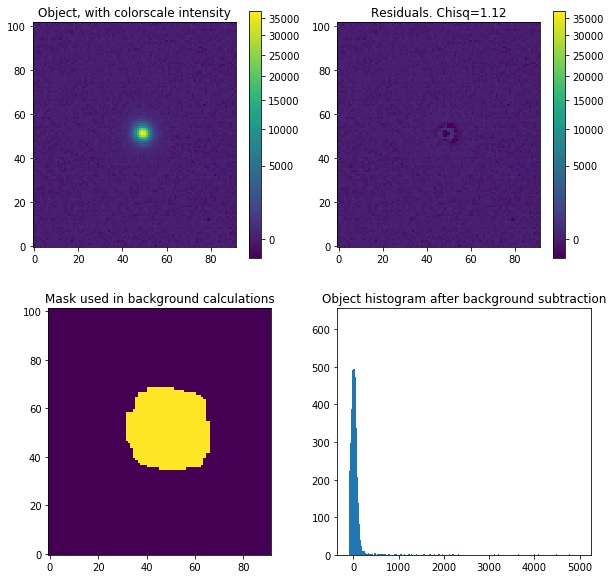

---------------------
Background mean: 3841.4901561286706
Background median: 3841.1026904055393
Background standerd deviation: 67.25174479429083


Resultant parameters
Flux: 216417.03±1484.98
Center (x, y): 51.22±0.01, 50.69±0.01
beta: 3.11±0.09
x-axis eccentricity: 3.91±0.09
y-axis eccentricity: 4.24±0.10
angle of eccentricity(Radians: 0.630±0.041
background: -0.16±0.71
Normalized chi squared: 
1.0432344153980067


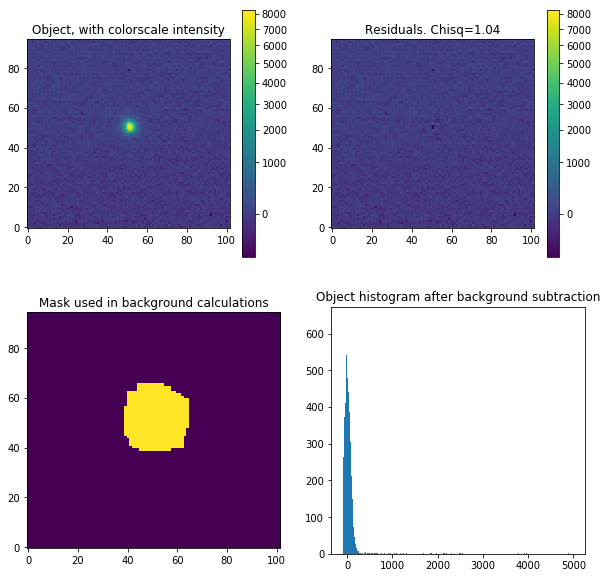

---------------------
Background mean: 4163.543128079858
Background median: 4162.8826904055395
Background standerd deviation: 64.98676545396009


Resultant parameters
Flux: 899909.61±1757.15
Center (x, y): 45.13±0.00, 36.60±0.00
beta: 3.35±0.03
x-axis eccentricity: 4.06±0.03
y-axis eccentricity: 4.25±0.03
angle of eccentricity(Radians: 0.599±0.023
background: 2.99±0.98
Normalized chi squared: 
1.1835364908569712


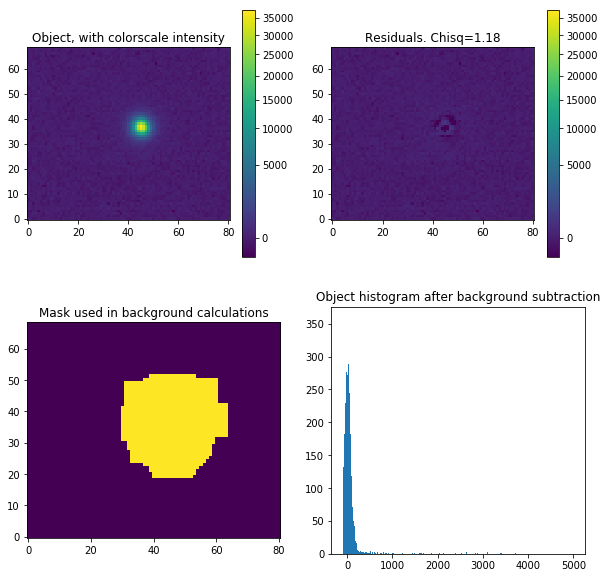

---------------------
Background mean: 4071.2882608325635
Background median: 4069.8826904055395
Background standerd deviation: 64.70712464190369


Resultant parameters
Flux: 195708.09±1344.96
Center (x, y): 29.54±0.01, 37.08±0.01
beta: 3.40±0.12
x-axis eccentricity: 4.07±0.10
y-axis eccentricity: 4.35±0.11
angle of eccentricity(Radians: 0.776±0.051
background: 0.43±0.94
Normalized chi squared: 
1.0600813882766125


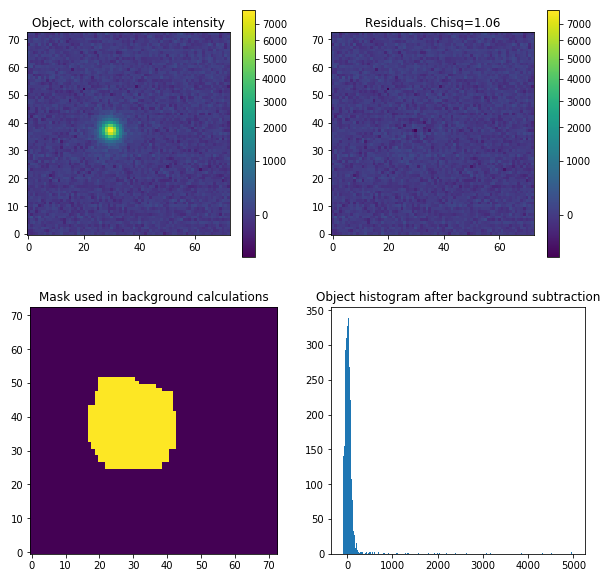

---------------------
Background mean: 4039.9730552324804
Background median: 4040.1226904055397
Background standerd deviation: 64.30846189454402


Unable to find fit.


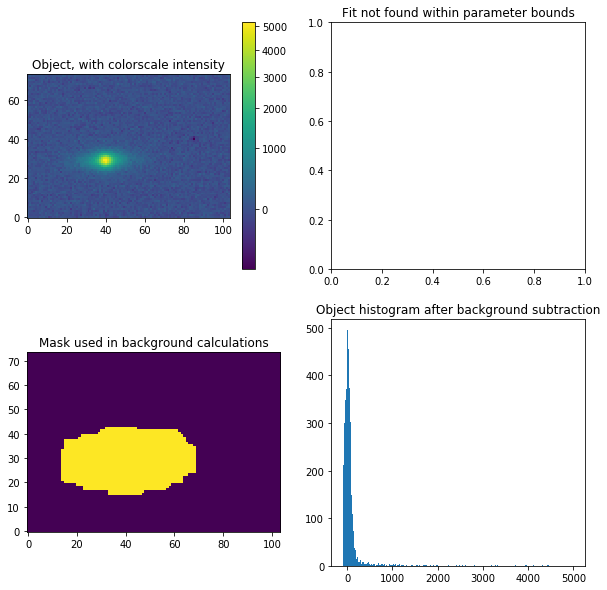

---------------------
Background mean: 3977.7591408428575
Background median: 3976.8826904055395
Background standerd deviation: 62.78809581349454


Resultant parameters
Flux: 721737.70±1613.19
Center (x, y): 41.23±0.00, 33.60±0.00
beta: 3.38±0.04
x-axis eccentricity: 4.10±0.04
y-axis eccentricity: 4.36±0.04
angle of eccentricity(Radians: 0.734±0.020
background: 1.75±0.86
Normalized chi squared: 
1.1339281908161367


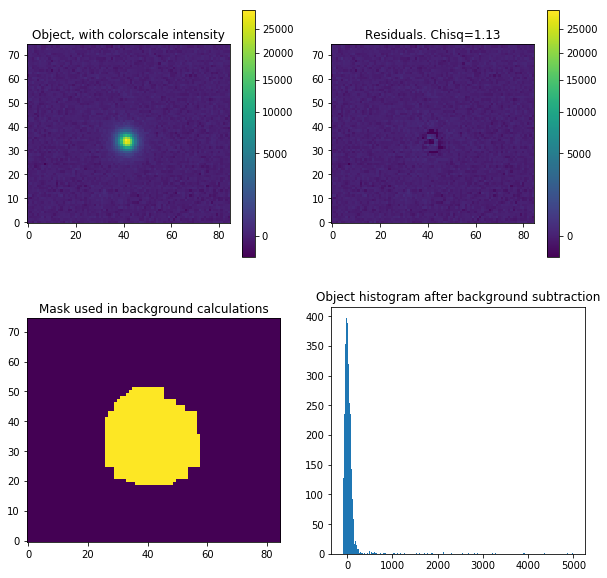

---------------------
Background mean: 4196.935729949117
Background median: 4196.36269040554
Background standerd deviation: 64.71895226471597


Resultant parameters
Flux: 1844459.36±2934.93
Center (x, y): 39.78±0.00, 39.73±0.00
beta: 4.44±0.05
x-axis eccentricity: 5.26±0.04
y-axis eccentricity: 5.44±0.04
angle of eccentricity(Radians: 0.630±0.028
background: 11.46±1.36
Normalized chi squared: 
2.563478496126242


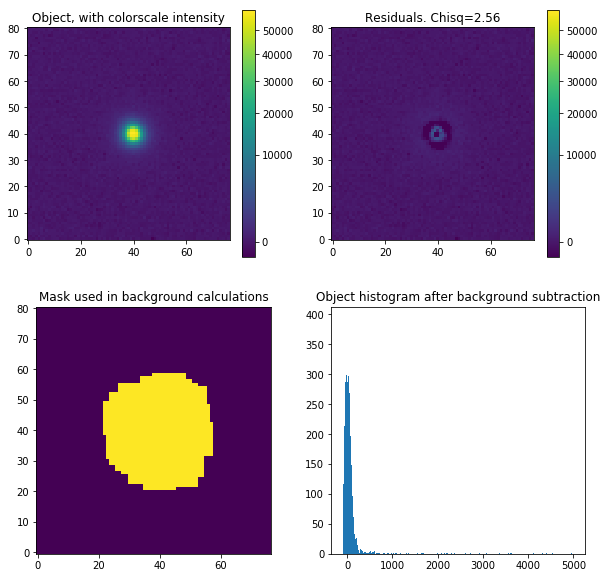

---------------------
Background mean: 3922.455225150741
Background median: 3922.9426904055395
Background standerd deviation: 62.02334091181817


Resultant parameters
Flux: 574995.33±1574.51
Center (x, y): 33.06±0.00, 31.31±0.00
beta: 3.34±0.05
x-axis eccentricity: 4.02±0.04
y-axis eccentricity: 4.37±0.05
angle of eccentricity(Radians: 0.725±0.017
background: 2.72±1.12
Normalized chi squared: 
1.1344711501214968


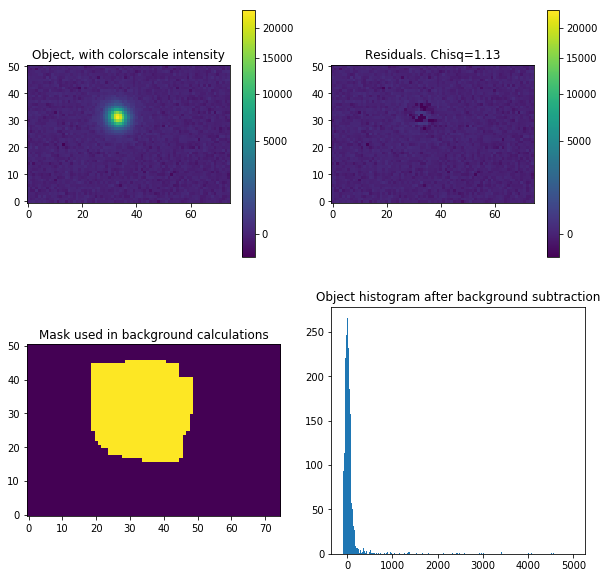

---------------------
Background mean: 4140.839891770727
Background median: 4142.4226904055395
Background standerd deviation: 63.49758500433429


Resultant parameters
Flux: 295227.10±1468.93
Center (x, y): 25.39±0.01, 23.09±0.01
beta: 3.31±0.08
x-axis eccentricity: 3.97±0.07
y-axis eccentricity: 4.14±0.07
angle of eccentricity(Radians: 0.661±0.058
background: 0.78±1.49
Normalized chi squared: 
1.118004315537496


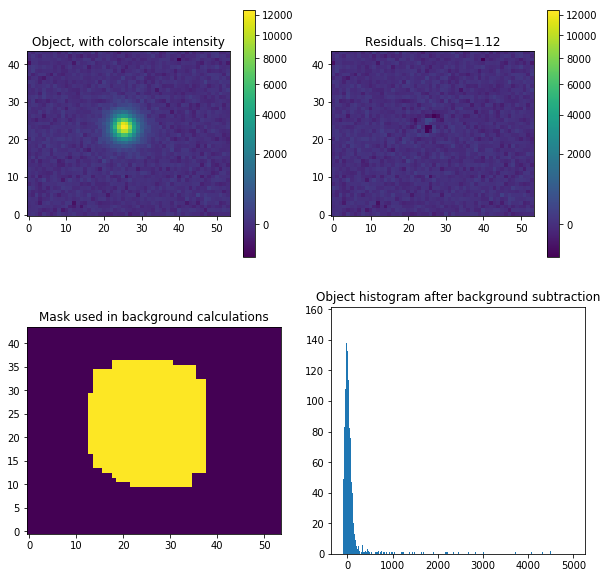

---------------------
Background mean: 4134.195503070448
Background median: 4134.98269040554
Background standerd deviation: 64.8332002578718


Resultant parameters
Flux: 43666.87±2656.56
Center (x, y): 26.96±0.06, 24.82±0.06
beta: 2.23±0.30
x-axis eccentricity: 3.71±0.40
y-axis eccentricity: 4.31±0.47
angle of eccentricity(Radians: 0.942±0.124
background: -1.40±1.72
Normalized chi squared: 
1.0574283892249374


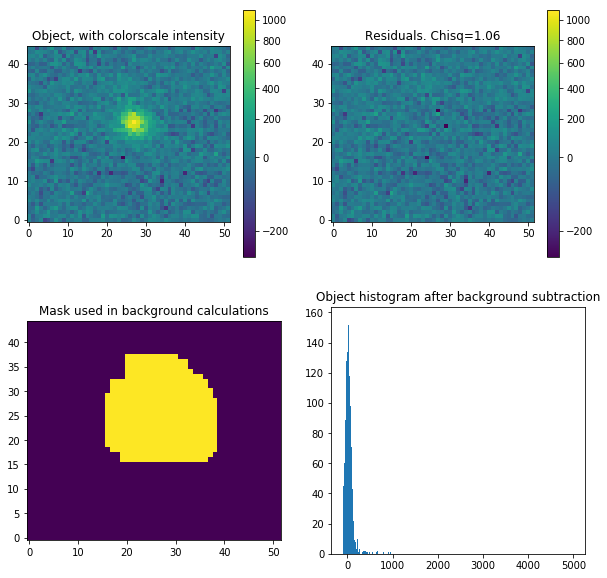

---------------------
Background mean: 3966.3402709607853
Background median: 3965.7226904055397
Background standerd deviation: 64.94105347150831


Resultant parameters
Flux: 3492161.84±6978.82
Center (x, y): 45.19±0.01, 48.47±0.01
beta: 20.00±1.60
x-axis eccentricity: 15.83±0.68
y-axis eccentricity: 16.93±0.72
angle of eccentricity(Radians: 0.718±0.018
background: 18.66±2.03
Normalized chi squared: 
10.662868886726088


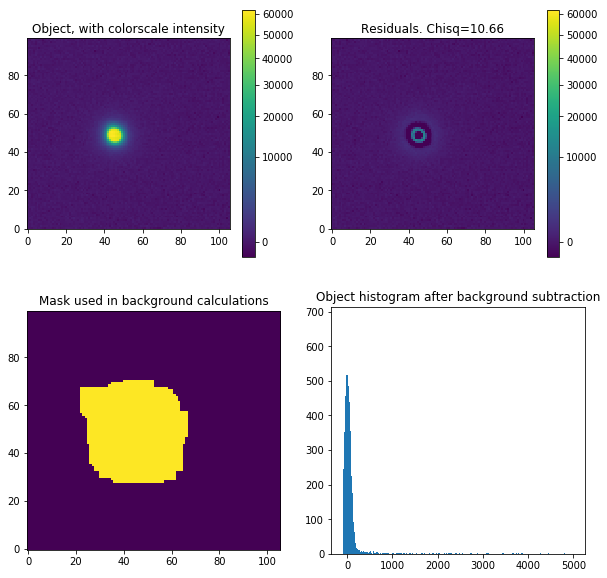

---------------------
Background mean: 4131.54140600187
Background median: 4131.26269040554
Background standerd deviation: 64.6150862195327


Resultant parameters
Flux: 33181.03±3744.90
Center (x, y): 16.10±0.08, 15.71±0.08
beta: 2.08±0.43
x-axis eccentricity: 3.94±0.64
y-axis eccentricity: 3.71±0.60
angle of eccentricity(Radians: 0.710±0.419
background: -4.69±3.47
Normalized chi squared: 
1.0480283853603518


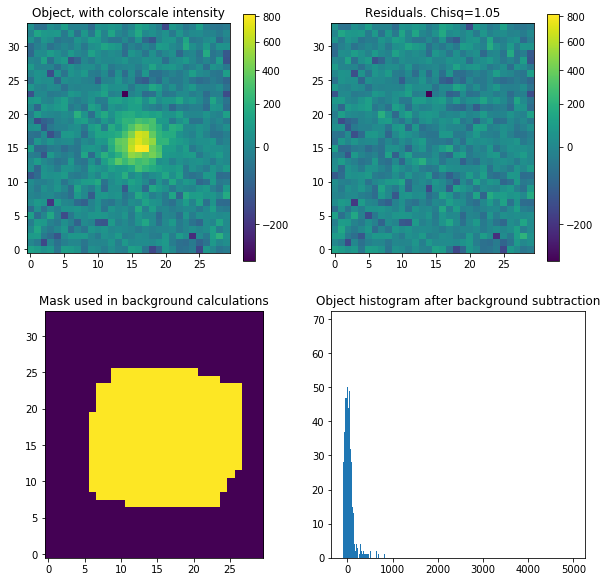

In [2]:


# check if ds9 is accesible
if not pyds9.ds9_targets():
    input('DS9 target not found. Please start/restart DS9, then press enter')

# show the ds9 target
print('ds9 target instance')
print(pyds9.ds9_targets())

# create a DS9 object
ds9 = pyds9.DS9()

# import the current fits file loaded in DS9
hdu = ds9.get_pyfits()

hdu.info()

# import a list of region definitions
selected_regions = get_regions(get_data=False)

# sort the regions according to the distance from origin
selected_regions.sort(key=lambda region: np.sqrt(region.x_coord**2 + region.y_coord**2))

# get the bias subtracted data
bias_subtracted_data = bias_subtract(hdu[0])
gain = hdu[0].header['GAIN']

# use the regions to produce apertures of thedata
# also background subtract the data
aperture_list = []  # list for holding aperture data
for region in selected_regions:
    current_aperture = bias_subtracted_data[region.ymin:region.ymax, region.xmin:region.xmax]

    # convert to electron count
    current_aperture = current_aperture*gain
    aperture_list.append(current_aperture)


"""calculate the centroid for each aperture"""



# generate each curve fit
from scipy.optimize import curve_fit
for aperture in aperture_list:

    print('---------------------')
    # background subtract the aperture
    aperture, mask, background_dev = background_subtract(aperture)

    # generate the associated pixel error
    aperture_err = np.sqrt(aperture + background_dev**2)

    # plot the aperture and mask used to background subtract
    norm = ImageNormalize(stretch=SqrtStretch())
    f1, axisarg = plt.subplots(2, 2, figsize=(10, 10))
    aperture_im = axisarg[0][0].imshow(aperture, norm=norm, origin='lower', cmap='viridis')
    f1.colorbar(aperture_im, ax=axisarg[0][0])
    axisarg[0][0].set_title('Object, with colorscale intensity')
    mask_im = axisarg[1][0].imshow(mask, origin='lower', cmap='viridis')
    axisarg[1][0].set_title('Mask used in background calculations')
    aperture_hist = axisarg[1][1].hist(aperture.flatten(),bins=500, range=[-100, 5000])
    axisarg[1][1].set_title('Object histogram after background subtraction')

    # create bounds for the fit, in an attempt to keep it from blowing up
    """
    flux_bound = [0, np.inf]
    x_bound = [0, object1_data.shape[1]]
    y_bound = [0, object1_data.shape[0]]
    beta_bound = [1, 20]]
    a_bound = [0.1, np.inf]
    b_bound = [0.1, np.inf]
    theta_bound = 0, np.pi/2]
    offset_bound = [-np.inf, np.inf]
    """
    # format the bounds
    lower_bounds = [0, 0, 0, 1, 0.1, 0.1, 0, -np.inf]
    upper_bounds = [np.inf, aperture.shape[1], aperture.shape[0], 20, np.inf, np.inf, np.pi/2,
                    np.inf]
    bounds = (lower_bounds, upper_bounds)  # bounds set as pair of array-like tuples

    # generate a best guess
    flux_guess = np.amax(aperture)*10
    y_guess = aperture.shape[0]/2
    x_guess = aperture.shape[1]/2
    beta_guess = 2
    a_guess = 2
    b_guess = 2
    theta_guess = 0
    offset_guess = 0

    guess = [flux_guess, x_guess, y_guess, beta_guess, a_guess, b_guess, theta_guess, offset_guess]

    # indexes of the apature, remembering that python indexes vert, horz
    y = np.arange(aperture.shape[0])
    x = np.arange(aperture.shape[1])
    x, y = np.meshgrid(x, y)


    # curve fit
    try:
        m_fit, m_cov = curve_fit(flat_elliptical_Moffat, (x, y), aperture.ravel(), sigma=aperture_err.ravel(), p0=guess,
                                 bounds=bounds)

    except RuntimeError:
        print('Unable to find fit.')
        axisarg[0][1].set_title('Fit not found within parameter bounds')
    else:

        error = np.sqrt(np.diag(m_cov))
        # print('Error on parameters')
        # print(error)

        x_center = m_fit[1]
        y_center = m_fit[2]
        x_width = m_fit[4]
        y_width = m_fit[5]

        """calculate the resulting plot from the fit"""

        # define the inputs for the elliptical Moffat
        m_input = (x, y)
        m_flux = m_fit[0]
        m_x0 = m_fit[1]
        m_y0 = m_fit[2]
        m_beta = m_fit[3]
        m_a = m_fit[4]
        m_b = m_fit[5]
        m_theta = m_fit[6]
        m_offset = m_fit[7]

        result = elliptical_Moffat(m_input, m_flux, m_x0, m_y0, m_beta, m_a, m_b, m_theta, m_offset)

        # calculate the difference between the obersved and the result fro mthe fit
        result_difference = aperture - result



        """Chi squared calculations"""
        observed = aperture.ravel()

        expected = flat_elliptical_Moffat(m_input, m_flux, m_x0, m_y0, m_beta, m_a, m_b, m_theta, m_offset)

        # calculated raw chi squared
        chisq = sum(np.divide((observed - expected) ** 2, expected + background_dev**2))

        # degrees of freedom, 5 parameters
        degrees_of_freedom = observed.size - 8

        # normalized chi squared
        chisq_norm = chisq / degrees_of_freedom

        #print the results
        print('Resultant parameters')
        print(f'Flux: {m_flux:.2f}±{error[0]:.2f}')
        print(f'Center (x, y): {m_x0:.2f}±{error[1]:.2f}, {m_y0:.2f}±{error[2]:.2f}')
        print(f'beta: {m_beta:.2f}±{error[3]:.2f}')
        print(f'x-axis eccentricity: {m_a:.2f}±{error[4]:.2f}')
        print(f'y-axis eccentricity: {m_b:.2f}±{error[5]:.2f}')
        print(f'angle of eccentricity(Radians: {m_theta:.3f}±{error[6]:.3f}')
        print(f'background: {m_offset:.2f}±{error[7]:.2f}')

        print('Normalized chi squared: ')
        print(chisq_norm)

        #plot it!
        residual_im = axisarg[0][1].imshow(result_difference, norm=norm, origin='lower', cmap='viridis')
        f1.colorbar(residual_im, ax=axisarg[0][1])
        axisarg[0][1].set_title(f'Residuals. Chisq={chisq_norm:.2f}')
        # add the calculated center and width bars to the aperture plot as a cross
        # The width of the lines correspond to the width in that direction
        # axisarg[0][0].errorbar(x_center, y_center, xerr=x_width, yerr=y_width, ecolor='red')
    plt.show()

